# Henry Gu - Advanced Machine Learning Assignment 5 - Ensemble Networks / Fashion MNIST Image Classification

Submitted the best scording model of the class with a Scoring Set Log Loss = 0.15751827840628077

Welcome to the final assignment in this course. It's been a long journey, but you are now ready to unleash the powers of neural networks at any task. In this assignment, we will be working with a collection of apparel and accessories images. Big online retailers routinely have to classify images provided by third-parties. Your task is to build a neural network that can classify theese images into one of 10 classes with the highest possible accuracy, and document your model's salient properties.

This assignment can be divided into the following sections:
1. downloading data
2. exploratory data analysis
3. data preprocessing
4. building and training
5. saving the model and predictions

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%config InlineBackend.figure_format = 'retina'

In [2]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2021-10-31 02:20:45.313096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-31 02:20:45.361857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 02:20:45.362657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-31 02:20:45.362880: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-31 02:20:45.364853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-31 02:20:45.366675: I tensorflow/stream_executor/platform/defaul

# Step 1: Download Data

The dataset is has been split into train (49k), validate (7k), test (7k), score (7k) segments.
No other data preprocessing was applied.

In [3]:
%%capture

## prefix redacted for privacy

# Feature variables for train, validate, and test segments
train_x = pd.read_parquet(f'{prefix}/train_x.parquet')
validate_x = pd.read_parquet(f'{prefix}/validate_x.parquet')
test_x = pd.read_parquet(f'{prefix}/test_x.parquet')

# Target variable to be predicted by the model for each segment
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

# This is the segment which you will be graded on
score_x = pd.read_parquet(f'{prefix}/score_x.parquet')

In [4]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]
classes = pd.DataFrame(
    data={
        'label': classes
    }
)
classes.index.name = 'class_id'
classes

,label
class_id,
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag


# Step 2: Exploratory Data Analysis

Before building a model, it's a good idea to take a look at the data.
Here are some suggested ideas to explore:
* Display the dataset's shape, mean, value ranges, and other simple statistics.
* Estimate the distribution of classes.
* Calcualte baseline model metrics (cross-entropy, accuracy, etc). Without a baseline, there is no meaningful point of reference to measure the success of a model or its attributes. Baseline models can be non-parametric (for this dataset, kNN would be the easiest to build), and parametric (unconditional mean, linear regression, random forest classifier, etc).

In [5]:
# Shape of data
train_x.shape, train_y.shape, validate_x.shape, validate_y.shape, test_x.shape, test_y.shape

((49000, 784), (49000, 1), (7000, 784), (7000, 1), (7000, 784), (7000, 1))

<AxesSubplot:>

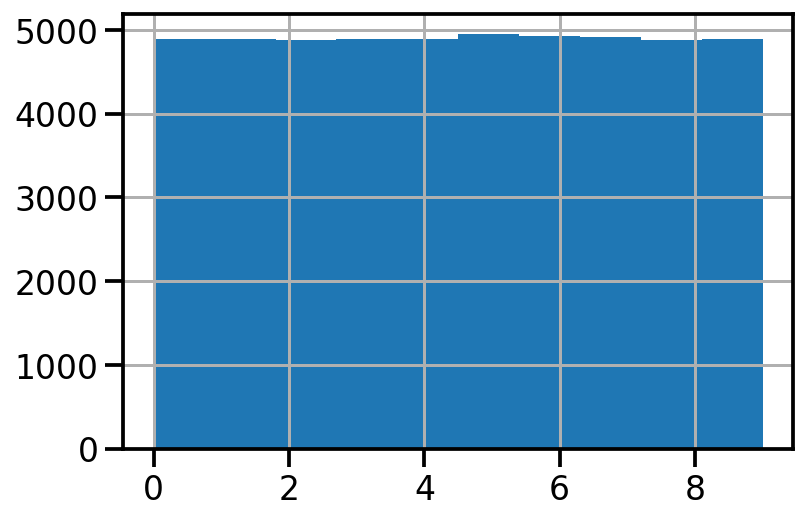

In [6]:
# Distribution of y labels in training
train_y['label'].hist()

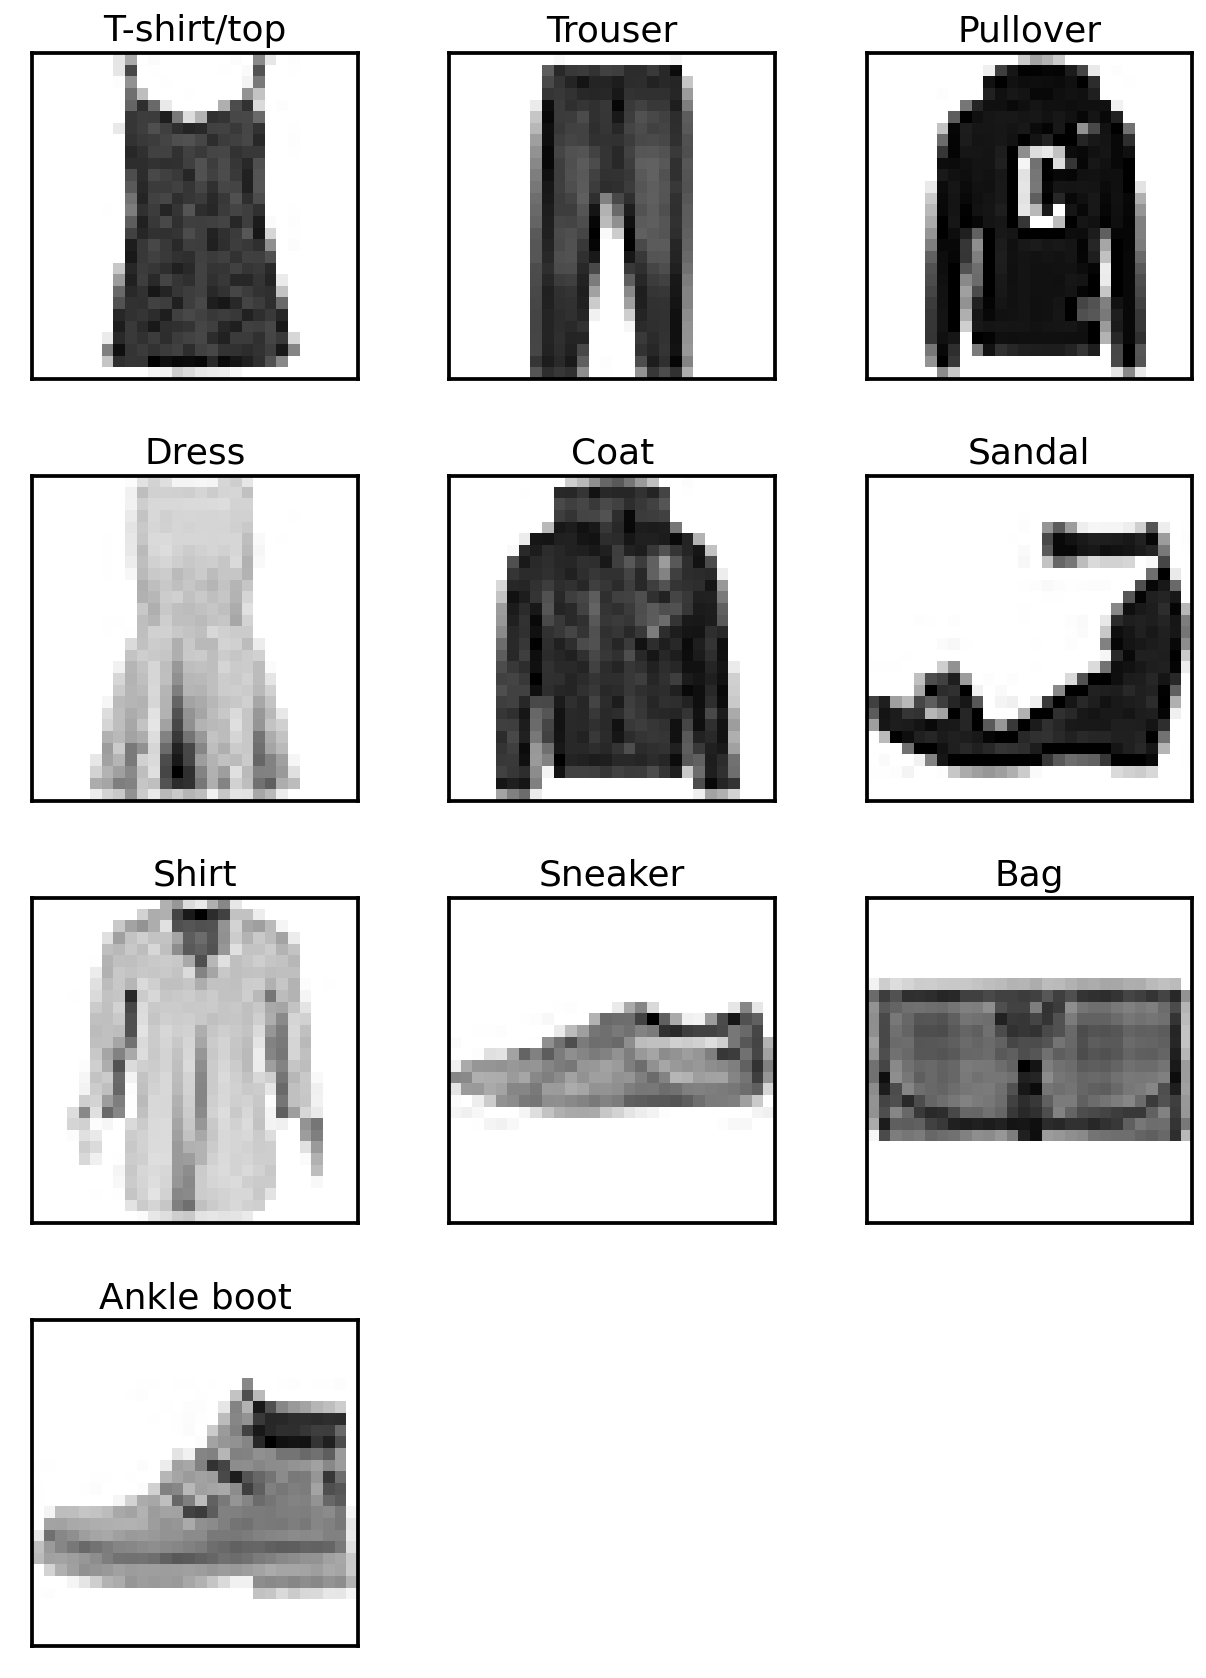

In [7]:
# This cell is plotting a random sample from each class.

n = classes.shape[0]
ncols = 3
nrows = math.ceil(n/ncols)

plt.figure(figsize=[3*ncols, 3*nrows])
for idx, cl in classes['label'].iteritems():
    plt.subplot(nrows, ncols, idx+1)
    
    img = train_x.loc[train_y['label'] == idx].sample(1)
    img = img.values.reshape(28, 28)
    plt.imshow(img, cmap='binary')
    
    plt.title(classes.loc[idx, 'label'])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

## Baseline Model

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [9]:
from sklearn.metrics import accuracy_score

print('Training set accuracy:', accuracy_score(train_y, knn.predict(train_x)))
print('Validation set accuracy:',accuracy_score(validate_y, knn.predict(validate_x)))
print('Test set accuracy:',accuracy_score(test_y, knn.predict(test_x)))

Training set accuracy: 0.8960408163265307
Validation set accuracy: 0.8538571428571429
Test set accuracy: 0.8505714285714285


Thus our model should reach at least a prediction of 85% accuracy or higher

# Step 3: Data Preprocessing

Next step is to transform the dataset for training. You are free to do any preprocesing that you would like.
Here are some suggestions that might or might not be useful for your model:
* standard scaling of the feature variables
* one-hot-encoding of the target variable
* reshaping the feature variables from 1D to 2D

And relevant documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

## OneHotEncode labels

In [10]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False).fit(np.array(range(10)).reshape(-1,1))
train_y_OH = OHE.transform(train_y)
validate_y_OH = OHE.transform(validate_y)
test_y_OH = OHE.transform(test_y)

train_y_OH.shape, validate_y_OH.shape, test_y_OH.shape

((49000, 10), (7000, 10), (7000, 10))

In [11]:
train_y_OH[:10], train_y[:10]

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
    label
 0      2
 1      9
 2      6
 3      0
 4      3
 5      4
 6      4
 7      5
 8      4
 9      8)

## Scale x values

In [34]:
train_x_scaled = train_x / 127.5 - 1
validate_x_scaled = validate_x / 127.5 - 1
test_x_scaled = test_x / 127.5 - 1
score_x_scaled = score_x / 127.5 - 1

train_x_scaled = train_x_scaled.values.reshape(-1,28,28,1)
validate_x_scaled = validate_x_scaled.values.reshape(-1,28,28,1)
test_x_scaled = test_x_scaled.values.reshape(-1,28,28,1)
score_x_scaled = score_x_scaled.values.reshape(-1,28,28,1)

print('Pre-transformation:\n', train_x.values.reshape(-1,28,28,1)[0,14,:,0])
print('Post-transformation:\n', train_x_scaled[0,14,:,0])
train_x_scaled.shape, validate_x_scaled.shape, test_x_scaled.shape

Pre-transformation:
 [  0  45 227 204 214 211 218 222 221 230 229 221 213 224 233 226 220 219
 221 224 223 217 210 218 213 254   0   0]
Post-transformation:
 [-1.         -0.64705882  0.78039216  0.6         0.67843137  0.65490196
  0.70980392  0.74117647  0.73333333  0.80392157  0.79607843  0.73333333
  0.67058824  0.75686275  0.82745098  0.77254902  0.7254902   0.71764706
  0.73333333  0.75686275  0.74901961  0.70196078  0.64705882  0.70980392
  0.67058824  0.99215686 -1.         -1.        ]


((49000, 28, 28, 1), (7000, 28, 28, 1), (7000, 28, 28, 1))

# Step 4: Building and training

Here comes the most challenging part. Are you ready to unleash the power of neural networks?
You can refer to the slides and discussion in the first lecture on hyperparameter optimization, random search, and greedy search.

## Define functions to build and train models

In [13]:
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.python import GlorotUniform
from sklearn.metrics import accuracy_score

def build_model(seed, lr=0.001):

    layers = [
        Conv2D(64, kernel_size=2, activation='relu', padding = 'same', input_shape=(28,28,1), kernel_initializer=GlorotUniform(seed=seed)),
        Conv2D(64, 2, activation='relu', padding = 'same', kernel_initializer=GlorotUniform(seed=seed+1)),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.3),
        Conv2D(128, 2, activation='relu', padding = 'same', kernel_initializer=GlorotUniform(seed=seed+2)),
        Conv2D(128, 2, activation='relu', padding = 'same', kernel_initializer=GlorotUniform(seed=seed+3)),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu', kernel_initializer=GlorotUniform(seed=seed+6)),
        Dropout(0.5),
        Dense(10, activation='softmax', kernel_initializer=GlorotUniform(seed=seed+7))
    ]

    model = Sequential(layers)

    model.compile(
        optimizer=optimizers.Adam(lr=lr), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

checkpoint_filepath = 'tmp/checkpoint'
verbose = 0

def train_model(model, x, y, epochs, batch_size, val_x, val_y, seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    history = model.fit(
        x=x, 
        y=y, 
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(val_x, val_y),
        callbacks=[
            ModelCheckpoint(
                filepath=checkpoint_filepath,
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
                mode="min",
                verbose=verbose
            ),
            EarlyStopping(
                patience=8,
                verbose=verbose
            )
        ],
        verbose=verbose
    )
    return history

def get_accuracy(model, test_x, test_y):
    y_pred = model.predict(test_x)
    y_pred = np.argmax(y_pred, axis=1)
    return accuracy_score(test_y, y_pred)

## Create the Ensemble Network

In [14]:
%%time

import random

np.random.seed(88)
num_models=10
noise_seeds = np.random.randint(8, 888, size=num_models)

lr = 0.0005
epochs = 50
batch_size = 128

noise_models = []
for i, seed in enumerate(noise_seeds):
    print('Training model:', i)
    noise_models.append(build_model(seed, lr=lr))
    train_model(noise_models[i], train_x_scaled, train_y_OH, epochs, batch_size, validate_x_scaled, validate_y_OH, seed=seed)
    noise_models[i].load_weights(checkpoint_filepath)
    print('Model', str(i), 'accuracy:', get_accuracy(noise_models[i], test_x_scaled, test_y))

Training model: 0


2021-10-31 02:23:15.594611: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-31 02:23:15.620824: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300010000 Hz
2021-10-31 02:23:15.621193: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55628d5d1ff0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-31 02:23:15.621217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-31 02:23:15.621544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 02:23:15.622359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tes

Model 0 accuracy: 0.9327142857142857
Training model: 1
Model 1 accuracy: 0.9398571428571428
Training model: 2
Model 2 accuracy: 0.9335714285714286
Training model: 3
Model 3 accuracy: 0.9322857142857143
Training model: 4
Model 4 accuracy: 0.934
Training model: 5
Model 5 accuracy: 0.9318571428571428
Training model: 6
Model 6 accuracy: 0.9325714285714286
Training model: 7
Model 7 accuracy: 0.932
Training model: 8
Model 8 accuracy: 0.9338571428571428
Training model: 9
Model 9 accuracy: 0.9338571428571428
CPU times: user 15min 45s, sys: 1min 14s, total: 16min 59s
Wall time: 53min 40s


## Evaluate Ensemble

By Probability Average

In [27]:
def ensemble_prediction(models, test_x):
    probs = np.array([
        model.predict(test_x)
        for model in models
    ])

    probs = probs.mean(axis=0)
    y_pred = np.argmax(probs, axis=1)
    return probs, y_pred

In [28]:
_, pred_test_y = ensemble_prediction(noise_models, test_x_scaled)
accuracy_score(test_y, pred_test_y)

0.9407142857142857

# Step 5: Saving the model and predictions

Save your predictions on the Score segment as a Pandas data frame into a variable named `score_y_hat`.

The expected shape of the submitted data frame is `(7000, 10)`, where each column is the probability for each class. The sum of probabilities have to add up to 1. The order of the column has to match the `classes` data frame defined above.

Finally, the data frame needs to have string column names in order to be saved as a Parquet file. If you convert a NumPy array to Pandas data frame, column names will be integers, but you can replace the columns names. There was a similar example of this in the notebook from the first assignment.

In order to verify that your score_y_hat has the right shape and column names,
you can run the following cell.

In [36]:
score_y_hat, _ = ensemble_prediction(noise_models, score_x_scaled)
score_y_hat = pd.DataFrame(score_y_hat, columns=classes['label'].values)
score_y_hat.head()

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,2.047934e-01,2.256062e-03,4.858882e-02,2.021590e-02,8.187805e-02,8.043348e-05,6.380376e-01,3.411299e-04,2.872858e-03,9.357335e-04
1,4.784512e-02,1.111009e-09,1.308919e-05,5.788889e-06,3.823113e-05,4.449794e-09,9.520977e-01,7.537201e-11,5.548124e-08,9.301132e-09
2,5.958437e-07,9.999992e-01,1.643721e-09,4.854685e-08,3.819252e-08,1.555080e-10,7.228057e-08,8.293011e-11,2.343562e-09,5.816053e-10
3,8.969299e-01,1.164739e-06,9.321991e-05,2.022364e-05,2.707479e-04,2.621634e-07,1.026822e-01,1.572853e-08,2.270499e-06,3.386782e-08
4,2.313501e-05,9.542439e-11,9.982399e-01,1.036136e-08,1.474959e-04,3.168449e-11,1.589259e-03,1.405862e-11,7.122772e-08,1.882257e-10


In [33]:
score_y_hat.shape, score_y_hat.columns

((7000, 10),
 Index(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
        'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
       dtype='object'))

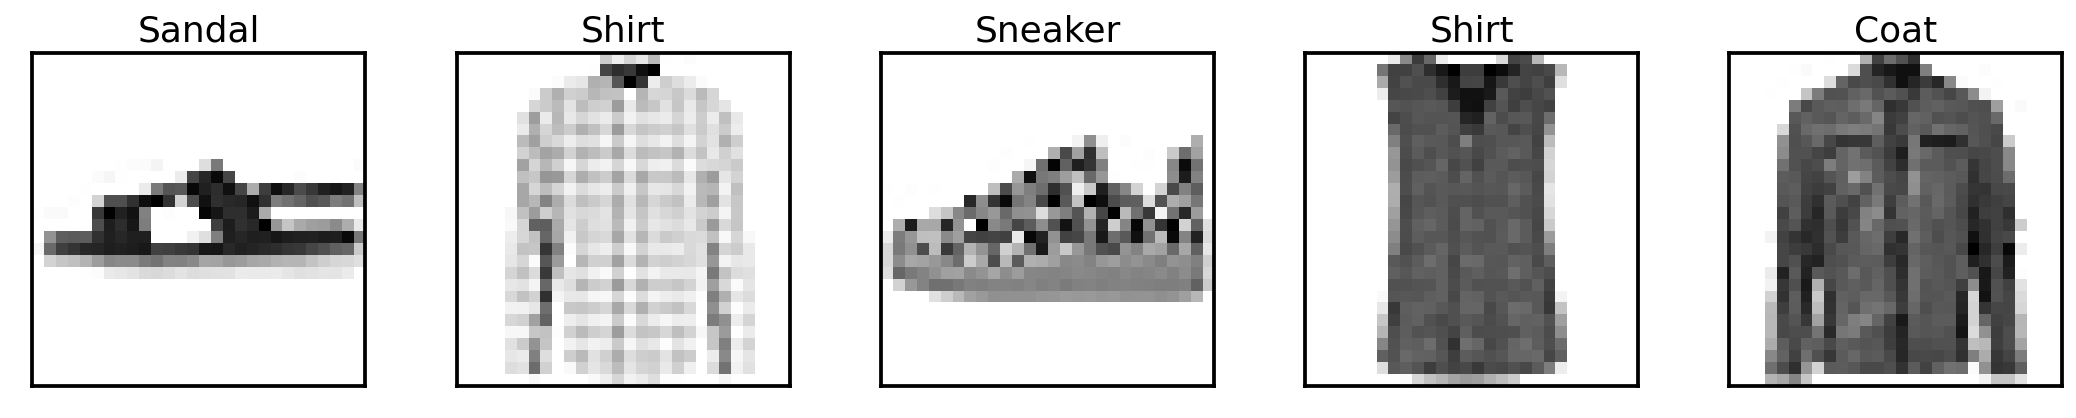

In [42]:
ncols = 5
nrows = 1

plt.figure(figsize=[3*ncols, 3*nrows])
for i in range(ncols):
    plt.subplot(nrows, ncols, i+1)
    
    rand_num = np.random.randint(0, score_x.shape[0]-1)
    img = score_x.iloc[rand_num]
    img = img.values.reshape(28, 28)
    plt.imshow(img, cmap='binary')
    
    plt.title(classes['label'].values[np.argmax(score_y_hat.iloc[rand_num])])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

In [43]:
# Once you are ready to make the graded submission,
# run the model on the score segment,
# and save the results as a Parquet file:

import os 
model_dir = 'fashionnet_model'
os.makedirs(model_dir, exist_ok=True)

score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

import json
for i, model in enumerate(noise_models):
    # Next, let's save the model's definition.
    with open(f'{model_dir}/keras_model_{i}.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))

    # Finally, let's save the learned parameters.
    model.save_weights(f"{model_dir}/keras_parameters_{i}.h5")

# You now have the following files to be submitted:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

# Discussion

**Data Pre-Processing**

To perform classification on this dataset, two pre-processing steps were required:
1. Scaling of the input data from range [0,255] to range [-1,1]. An output range of [0,1] was also tested, however from the test samples, it performed marginally worse.
2. One Hot Encoding of the labels, converting the labels from numeric values in the range [0,9] to (1, 10) vector representations for each sample.

**Models Considered**

In building the final model, three model architectures were considered:

1. Transfer Learning Using MobileNetV2

I considered utilising transfer learning by leveraging the pre-trained MobileNetV2 network. Setup to use this model architecture involved upscaling the input images to 56 x 56, as MobileNet required inputs larger than 32 x 32, and artificially creating three colour channels by duplicating the input vector across three channels. 

2. ConvPool-CNN [Springenberg et al., 2015, Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)

From reviewing the literature, an interesting model architecture which I came across was a CNN model which did not utilise Dense layers for computing classes. Instead, a 10 unit Convolution layer and GlobalAveragePooling layer is used. I was interested to see how this architecture would perform compared to a more traditional CNN structure.

3. Standard CNN

The final architecture I considered was modelled after the VGGNet model insights we discussed in class. Namely, this architecture used smaller filter surface areas and more layers to generate predictions.

**Single Model Design and Hyperparameter Selection**

After considering some baseline cases for each architecture, I settled on an ensemble of architecture 3 for the final model. This was due to two main reasons. Firstly, during my baseline testing, I discovered that on average, the traditional CNN architecture had a greater test set accuracy than the other two architectures, with the Transfer Learning model averaging ~90% accuracy, the ConvPool-CNN averaging ~92.5% accuracy, and the Standard CNN averaging ~93.5% accuracy. Secondly, I noted that the Standard CNN model took a shorter amount of time to train compared to the other two architectures. Due to these considerations, I settled on using only Standard CNN models.

Whilst testing each of the architectures, a number of hyperparameters were considered. For MobileNetV2, the main consideration was the number of units in the dense layers on top of the model, as well as the learning rate. However, no combination tested enabled performance to exceeed 90% test set accuracy significantly. For architectures 2 and 3, I tested different combinations of learning rate, units per layer and number of layers. The values tested were:
- Learning Rate: 0.001, 0.0001
- Units per Conv2D Layer: 64/128, 96/192
- Units for Dense Layer: 128, 256, 512
- Number of Layers: 1, 2, 3

I made the following conclusions:
- Learning Rate should be set between 0.001 and 0.0001. At 0.001, the validation error tended to be unstable and seemed to miss the local minima. At 0.0001, the model was more stable but training time increased significantly. A test at 0.0005 had relatively good results and was thus used in the final model.
- Reducing the number of units in the Conv2D layers seemed to provide similar test set accuracy whilst decreasing training time in general. Thus 64/128 was used.
- Changing the number of units in the Dense layer seemed to result in a parabolic change to test set accuracy. The test set accuracy was highest at 256 and lower at 128 and 512. Thus I used 256 units.
- Removing the third layer improved test set accuracy and also increased training speed. Removing the second layer sacrificed some accuracy for increased training time. Since training time was not too long, the second layer was kept to keep the marginal gain in test set accuracy observed during tests.

**Ensemble Design and Considerations**

I chose to utilise 10 individuals models in my final ensemble to keep total training time of the ensemble to below 1 hour. I used only model architecture 2 as it performed the best on the single model tests. To reduce error correlation between each model in the ensemble, I utilised Dropout layers during training and ensured that each single model had different initial kernal weights by using random seeds.

For predictions from the ensemble, I considered two decision choices. The first was by average prediction probability across the 10 single models. The second was the highest frequency vote across the 10 single models. Ultimately I chose the average prediction probability due to better performance in testing and due to theory.